In [1]:
import xarray as xr
import numpy as np
import geopandas as gpd
import xvec

from rasterio.enums import Resampling

from scipy.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import math
import statistics as stats

import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
from dask.distributed import LocalCluster

cluster = LocalCluster(n_workers = 10, threads_per_worker = 10, memory_limit = 0) # Refined through testing
client = cluster.get_client()
client # Can open in other window by clicking 'Dashboard' link below

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 100,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64604,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 100
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:64660,Total threads: 10
Dashboard: http://127.0.0.1:64674/status,Memory: 0 B
Nanny: tcp://127.0.0.1:64607,


# Extent Shapefiles

## HV

In [3]:
hv_shp = gpd.read_file(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\Fmask_V1\AA\Alaska Snow Depth\Extent\HV.shp")
hv_shp

,Id,gridcode,geometry
0,1,0,"POLYGON ((424400 7662600, 421000 7662600, 4210..."


## CLPX

In [4]:
clpx_shp = gpd.read_file(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\Fmask_V1\AA\Alaska Snow Depth\Extent\CLPX.shp")
clpx_shp

,Id,gridcode,geometry
0,1,0,"POLYGON ((415650 7609100, 401900 7609100, 4019..."


## Water

In [5]:
water_shp = gpd.read_file(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\Fmask_V1\AA\Alaska Snow Depth\Extent\water.shp")
water_shp

,Id,Site,geometry
0,0,HV,"POLYGON ((422830.677 7675613.835, 422834.117 7..."
1,0,HV,"POLYGON ((422592.022 7675128.059, 422596.52 76..."
2,0,HV,"POLYGON ((422658.697 7674925.123, 422653.67 76..."
3,0,HV,"POLYGON ((422631.445 7674893.902, 422638.589 7..."
4,0,HV,"POLYGON ((422341.461 7674620.322, 422347.811 7..."
...,...,...,...
160,0,CLPX,"POLYGON ((413033.401 7609893.32, 413045.043 76..."
161,0,CLPX,"POLYGON ((410057.362 7609525.284, 410041.487 7..."
162,0,CLPX,"POLYGON ((410319.3 7609151.162, 410271.675 760..."
163,0,CLPX,"POLYGON ((411124.428 7609163.597, 411122.312 7..."


In [6]:
len(water_shp[water_shp['Site'] == 'HV'])

39

In [7]:
len(water_shp[water_shp['Site'] == 'CLPX'])

126

# Initial Snow Depth (1m)

## HV

In [8]:
hv = xr.open_dataarray(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\Fmask_V1\AA\Alaska Snow Depth\Comparison with Snow Depth\HV_SnowDepth_1m_orginal.tif",
                       chunks = {'band': 1, 'x': -1, 'y': -1})
hv

<xarray.DataArray 'band_data' (band: 6, y: 15400, x: 3400)> Size: 1GB
dask.array<open_dataset-band_data, shape=(6, 15400, 3400), dtype=float32, chunksize=(1, 15400, 3400), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 27kB 4.21e+05 4.21e+05 ... 4.244e+05 4.244e+05
  * y            (y) float64 123kB 7.678e+06 7.678e+06 ... 7.663e+06 7.663e+06
    spatial_ref  int64 8B ...
Attributes:
    DataType:                Generic
    AREA_OR_POINT:           Area
    RepresentationType:      ATHEMATIC
    STATISTICS_COUNT:        52360000.0
    STATISTICS_COVARIANCES:  24883719.31115343,23847878.42583052,23281998.078...
    STATISTICS_MAXIMUM:      19.349592208862
    STATISTICS_MEAN:         -4660.7631517286
    STATISTICS_MEDIAN:       -19.938053
    STATISTICS_MINIMUM:      -9999
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       4988.3583783799

In [9]:
hv.rio.crs

CRS.from_wkt('PROJCS["UTM_Zone_6_Northern_Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32606"]]')

In [10]:
#hv.isnull().sum().compute() # 0

## CLPX

In [11]:
clpx = xr.open_dataarray(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\Fmask_V1\AA\Alaska Snow Depth\Comparison with Snow Depth\CLPX_SnowDepth_1m_orginal.tif",
                       chunks = {'band': 1, 'x': -1, 'y': -1})
clpx

<xarray.DataArray 'band_data' (band: 6, y: 11100, x: 13750)> Size: 4GB
dask.array<open_dataset-band_data, shape=(6, 11100, 13750), dtype=float32, chunksize=(1, 11100, 13750), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 110kB 4.019e+05 4.019e+05 ... 4.156e+05 4.156e+05
  * y            (y) float64 89kB 7.62e+06 7.62e+06 ... 7.609e+06 7.609e+06
    spatial_ref  int64 8B ...
Attributes:
    DataType:                Generic
    AREA_OR_POINT:           Area
    RepresentationType:      ATHEMATIC
    STATISTICS_COUNT:        152625000.0
    STATISTICS_COVARIANCES:  24994029.76247728,23706407.11463305,18806711.686...
    STATISTICS_MAXIMUM:      7.2319602966309
    STATISTICS_MEAN:         -4946.5423249399
    STATISTICS_MEDIAN:       -32.008165
    STATISTICS_MINIMUM:      -9999
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       4999.4029405997

In [12]:
clpx.rio.crs
crs = clpx.rio.crs

In [13]:
# clpx.isnull().sum().compute() # 0

# Convert band names to ordered years
- For HV: 1 = 2018, 2 = 2017, 3 = 2016, 4 = 2015, 5 = 2013, 6 = 2012
- For CLPX: 1 = 2012, 2 = 2013, 3 = 2015, 4 = 2017, 5 = 2018, 6 = 2016

## HV

In [14]:
yrs_hv = np.array([2018, 2017, 2016, 2015, 2013, 2012])

hv = hv.rename({'band': 'year'}).assign_coords(year = ('year', yrs_hv)).sortby('year')
hv

<xarray.DataArray 'band_data' (year: 6, y: 15400, x: 3400)> Size: 1GB
dask.array<getitem, shape=(6, 15400, 3400), dtype=float32, chunksize=(1, 15400, 3400), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 27kB 4.21e+05 4.21e+05 ... 4.244e+05 4.244e+05
  * y            (y) float64 123kB 7.678e+06 7.678e+06 ... 7.663e+06 7.663e+06
    spatial_ref  int64 8B ...
  * year         (year) int64 48B 2012 2013 2015 2016 2017 2018
Attributes:
    DataType:                Generic
    AREA_OR_POINT:           Area
    RepresentationType:      ATHEMATIC
    STATISTICS_COUNT:        52360000.0
    STATISTICS_COVARIANCES:  24883719.31115343,23847878.42583052,23281998.078...
    STATISTICS_MAXIMUM:      19.349592208862
    STATISTICS_MEAN:         -4660.7631517286
    STATISTICS_MEDIAN:       -19.938053
    STATISTICS_MINIMUM:      -9999
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       4988.3583783799

In [15]:
#hv.mean(dim = ('x', 'y')).compute()

## CLPX

In [16]:
yrs_clpx = np.array([2012, 2013, 2015, 2017, 2018, 2016])

clpx = clpx.rename({'band': 'year'}).assign_coords(year = ('year', yrs_clpx)).sortby('year')
clpx

<xarray.DataArray 'band_data' (year: 6, y: 11100, x: 13750)> Size: 4GB
dask.array<getitem, shape=(6, 11100, 13750), dtype=float32, chunksize=(1, 11100, 13750), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 110kB 4.019e+05 4.019e+05 ... 4.156e+05 4.156e+05
  * y            (y) float64 89kB 7.62e+06 7.62e+06 ... 7.609e+06 7.609e+06
    spatial_ref  int64 8B ...
  * year         (year) int64 48B 2012 2013 2015 2016 2017 2018
Attributes:
    DataType:                Generic
    AREA_OR_POINT:           Area
    RepresentationType:      ATHEMATIC
    STATISTICS_COUNT:        152625000.0
    STATISTICS_COVARIANCES:  24994029.76247728,23706407.11463305,18806711.686...
    STATISTICS_MAXIMUM:      7.2319602966309
    STATISTICS_MEAN:         -4946.5423249399
    STATISTICS_MEDIAN:       -32.008165
    STATISTICS_MINIMUM:      -9999
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       4999.4029405997

In [17]:
#clpx.mean(dim = ('x', 'y')).compute()

# Set -9999 to NaN

## HV

In [18]:
hv = xr.where(hv == -9999, np.nan, hv)
hv.rio.write_crs(crs, inplace = True)
hv

<xarray.DataArray 'band_data' (year: 6, y: 15400, x: 3400)> Size: 1GB
dask.array<where, shape=(6, 15400, 3400), dtype=float32, chunksize=(1, 15400, 3400), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 27kB 4.21e+05 4.21e+05 ... 4.244e+05 4.244e+05
  * y            (y) float64 123kB 7.678e+06 7.678e+06 ... 7.663e+06 7.663e+06
  * year         (year) int64 48B 2012 2013 2015 2016 2017 2018
    spatial_ref  int64 8B 0

In [19]:
hv.rio.crs

CRS.from_wkt('PROJCS["UTM_Zone_6_Northern_Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32606"]]')

In [20]:
#hv.isnull().sum().compute() # 163933837

## CLPX

In [21]:
clpx = xr.where(clpx == -9999, np.nan, clpx)
clpx.rio.write_crs(crs, inplace = True)
clpx

<xarray.DataArray 'band_data' (year: 6, y: 11100, x: 13750)> Size: 4GB
dask.array<where, shape=(6, 11100, 13750), dtype=float32, chunksize=(1, 11100, 13750), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 110kB 4.019e+05 4.019e+05 ... 4.156e+05 4.156e+05
  * y            (y) float64 89kB 7.62e+06 7.62e+06 ... 7.609e+06 7.609e+06
  * year         (year) int64 48B 2012 2013 2015 2016 2017 2018
    spatial_ref  int64 8B 0

In [22]:
clpx.rio.crs

CRS.from_wkt('PROJCS["UTM_Zone_6_Northern_Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32606"]]')

In [23]:
#clpx.isnull().sum().compute() # 383082613

# Check histograms...
- Min should be 0
- Trim max to 5 m (Parr 2020, Gisnas 2014)

## HV

In [24]:
#hv.min().compute() # 0

In [25]:
hv = xr.where(hv > 5, 5, hv)
hv.rio.write_crs(crs, inplace = True)
hv

<xarray.DataArray 'band_data' (year: 6, y: 15400, x: 3400)> Size: 1GB
dask.array<where, shape=(6, 15400, 3400), dtype=float32, chunksize=(1, 15400, 3400), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 27kB 4.21e+05 4.21e+05 ... 4.244e+05 4.244e+05
  * y            (y) float64 123kB 7.678e+06 7.678e+06 ... 7.663e+06 7.663e+06
  * year         (year) int64 48B 2012 2013 2015 2016 2017 2018
    spatial_ref  int64 8B 0

In [26]:
# hv.plot(bins = 100)
# plt.show()

## CLPX

In [27]:
#clpx.min().compute() # 0

In [28]:
clpx = xr.where(clpx > 5, 5, clpx)
clpx.rio.write_crs(crs, inplace = True)
clpx

<xarray.DataArray 'band_data' (year: 6, y: 11100, x: 13750)> Size: 4GB
dask.array<where, shape=(6, 11100, 13750), dtype=float32, chunksize=(1, 11100, 13750), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 110kB 4.019e+05 4.019e+05 ... 4.156e+05 4.156e+05
  * y            (y) float64 89kB 7.62e+06 7.62e+06 ... 7.609e+06 7.609e+06
  * year         (year) int64 48B 2012 2013 2015 2016 2017 2018
    spatial_ref  int64 8B 0

In [29]:
# clpx.plot(bins = 100)
# plt.show()

# HLS Snow End
- Load
- Clip to CLPX and HW

## 2018-2023 Weighted Mean

In [30]:
hls1823wm = xr.open_dataarray(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\Fmask_V1\AA\Alaska Snow Depth\3 HLS snowDynamics\is_7\interannual\HLS_Fmask_snow_end_mn_1823_AlaskaSite.tif",
                              chunks = {'band': 1, 'x': -1, 'y': -1}).squeeze()
hls1823wm

<xarray.DataArray 'band_data' (y: 2436, x: 1581)> Size: 15MB
dask.array<getitem, shape=(2436, 1581), dtype=float32, chunksize=(2436, 1581), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 13kB 3.995e+05 3.996e+05 ... 4.469e+05 4.469e+05
  * y            (y) float64 19kB 7.679e+06 7.679e+06 ... 7.606e+06 7.606e+06
    spatial_ref  int64 8B ...
Attributes:
    TIFFTAG_SOFTWARE:        GDAL 3.7.0e (3070046) (4.5.1;1700;3.0.0;2.0.7;;;...
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  42.8449049975717
    STATISTICS_MAXIMUM:      175.98905944824
    STATISTICS_MEAN:         146.75786392221
    STATISTICS_MINIMUM:      73.134407043457
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       6.5456019583818
    long_name:               snow_end_mn

### HV

In [31]:
hls1823wm_hv = hls1823wm.rio.clip(hv_shp.geometry.values)
hls1823wm_hv

<xarray.DataArray 'band_data' (y: 513, x: 114)> Size: 234kB
dask.array<getitem, shape=(513, 114), dtype=float32, chunksize=(513, 114), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 912B 4.21e+05 4.21e+05 ... 4.244e+05 4.244e+05
  * y            (y) float64 4kB 7.678e+06 7.678e+06 ... 7.663e+06 7.663e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        GDAL 3.7.0e (3070046) (4.5.1;1700;3.0.0;2.0.7;;;...
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  42.8449049975717
    STATISTICS_MAXIMUM:      175.98905944824
    STATISTICS_MEAN:         146.75786392221
    STATISTICS_MINIMUM:      73.134407043457
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       6.5456019583818
    long_name:               snow_end_mn

In [32]:
hls1823wm_hv.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 6N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32606"]]')

In [33]:
# hls1823wm_hv.plot()

In [34]:
# #hls1823wm_hv = hls1823wm_hv.squeeze().to_dataframe('snow_end')
# hls1823wm_hv = hls1823wm_hv.squeeze().xvec.to_geodataframe()
# hls1823wm_hv

In [35]:
# type(hls1823wm_hv)

In [36]:
# Idea of converting to geodataframe fishnet and getting mean of 1m data within each pixel... 
# https://support.esri.com/en-us/knowledge-base/how-to-convert-a-floating-type-raster-to-a-polygon-feat-000028071
# https://stackoverflow.com/questions/65504116/how-to-convert-a-xarray-dataarray-to-a-geopandas-geodataframe

### CLPX

In [37]:
hls1823wm_clpx = hls1823wm.rio.clip(clpx_shp.geometry.values)
hls1823wm_clpx

<xarray.DataArray 'band_data' (y: 370, x: 458)> Size: 678kB
dask.array<getitem, shape=(370, 458), dtype=float32, chunksize=(370, 458), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 4kB 4.019e+05 4.02e+05 ... 4.156e+05 4.156e+05
  * y            (y) float64 3kB 7.62e+06 7.62e+06 ... 7.609e+06 7.609e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        GDAL 3.7.0e (3070046) (4.5.1;1700;3.0.0;2.0.7;;;...
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  42.8449049975717
    STATISTICS_MAXIMUM:      175.98905944824
    STATISTICS_MEAN:         146.75786392221
    STATISTICS_MINIMUM:      73.134407043457
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       6.5456019583818
    long_name:               snow_end_mn

In [38]:
hls1823wm_clpx.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 6N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32606"]]')

In [39]:
# hls1823wm_clpx.plot()

## 2018-2023 Best Value

In [40]:
# hls1823bv = xr.open_dataarray(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\Fmask_V1\AA\Alaska Snow Depth\3 HLS snowDynamics\is_7\interannual\HLS_Fmask_snow_length_bv_1823_AlaskaSite.tif",
#                               chunks = {'band': 1, 'x': -1, 'y': -1}).squeeze()
# hls1823bv_hv = hls1823bv.rio.clip(hv_shp.geometry.values)
# hls1823bv_clpx = hls1823bv.rio.clip(clpx_shp.geometry.values)
# hls1823bv_clpx

## 2018-2019

In [41]:
# hls1819 = xr.open_dataarray(r"\\W-BSC-A151821\WP_Permafrost_HBL2\HLSsnowDynamics\Alaska\3 HLS snowDynamics\is_7\winterYear\1819\HLS_Fmask_snow_end_winterYear1819_AlaskaSite.tif",
#                             chunks = {'band': 1, 'x': -1, 'y': -1}).squeeze()
# hls1819_hv = hls1819.rio.clip(hv_shp.geometry.values)
# hls1819_clpx = hls1819.rio.clip(clpx_shp.geometry.values)
# hls1819_clpx

## 2019-2020

In [42]:
# hls1920 = xr.open_dataarray(r"\\W-BSC-A151821\WP_Permafrost_HBL2\HLSsnowDynamics\Alaska\3 HLS snowDynamics\is_7\winterYear\1920\HLS_Fmask_snow_end_winterYear1920_AlaskaSite.tif",
#                             chunks = {'band': 1, 'x': -1, 'y': -1}).squeeze()
# hls1920_hv = hls1920.rio.clip(hv_shp.geometry.values)
# hls1920_clpx = hls1920.rio.clip(clpx_shp.geometry.values)
# hls1920_clpx

## 2020-2021

In [43]:
# hls2021 = xr.open_dataarray(r"\\W-BSC-A151821\WP_Permafrost_HBL2\HLSsnowDynamics\Alaska\3 HLS snowDynamics\is_7\winterYear\2021\HLS_Fmask_snow_end_winterYear2021_AlaskaSite.tif",
#                             chunks = {'band': 1, 'x': -1, 'y': -1}).squeeze()
# hls2021_hv = hls2021.rio.clip(hv_shp.geometry.values)
# hls2021_clpx = hls2021.rio.clip(clpx_shp.geometry.values)
# hls2021_clpx

## 2021-2022

In [44]:
# hls2122 = xr.open_dataarray(r"\\W-BSC-A151821\WP_Permafrost_HBL2\HLSsnowDynamics\Alaska\3 HLS snowDynamics\is_7\winterYear\2122\HLS_Fmask_snow_end_winterYear2122_AlaskaSite.tif",
#                             chunks = {'band': 1, 'x': -1, 'y': -1}).squeeze()
# hls2122_hv = hls2122.rio.clip(hv_shp.geometry.values)
# hls2122_clpx = hls2122.rio.clip(clpx_shp.geometry.values)
# hls2122_clpx

## 2022-2023

In [45]:
# hls2223 = xr.open_dataarray(r"\\W-BSC-A151821\WP_Permafrost_HBL2\HLSsnowDynamics\Alaska\3 HLS snowDynamics\is_7\winterYear\2223\HLS_Fmask_snow_end_winterYear2223_AlaskaSite.tif",
#                             chunks = {'band': 1, 'x': -1, 'y': -1}).squeeze()
# hls2223_hv = hls2223.rio.clip(hv_shp.geometry.values)
# hls2223_clpx = hls2223.rio.clip(clpx_shp.geometry.values)
# hls2223_clpx

# Reproject Snow Depth (1m) to 30m, matching pixel grid
- Mean (median highly correlated, no real difference...)
- Note: Only outputs reprojected 30 m pixel value if no NaN values in 1 m product - which is good (no edge effects etc)

## HV

In [46]:
hv30 = hv.rio.reproject_match(match_data_array = hls1823wm_hv, resampling = Resampling.average)
hv30

<xarray.DataArray 'band_data' (year: 6, y: 513, x: 114)> Size: 1MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ..., 0.70507884,
         0.50482583, 0.2341651 ],
        [       nan,        nan,        nan, ..., 0.86808056,
         0.45011085, 0.2254244 ],
        [       nan,        nan,        nan, ..., 0.80263835,
         0.33121574, 0.2621996 ]],

       [[       nan, 0.76419455, 0.73520404, ...,        nan,
                nan,        nan],
        [       nan, 0.6872949 , 0.70466363, ...,        nan,
                nan,        nan],
        [       nan, 0.69325286, 0.6785072 , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * year         (year) int64 48B 2012 2013 2015 2016 2017 2018
    spatial_ref  int64 8B 0
  * x            (x) float64 912B 4.21e+05 4.21e+05 ... 4.244e+05 4.244e+05
  * y            (y) float64 4kB 7.678e+06 7.678e+06 ... 7.663e+06 7.663e+06
Attributes:
    _FillValue:  nan

In [47]:
#hv30[5].rio.to_raster('test.tif') # 2018 # Looks good in ArcGIS Pro
#hv30[0].rio.to_raster('test.tif') # 2018 # Looks good in ArcGIS Pro (Note: Only outputs 30 m pixel if no NaN values in 1 m) - which is good

In [48]:
# hv30m = hv.rio.reproject_match(match_data_array = hls1823wm_hv, resampling = Resampling.med)
# hv30m

In [49]:
# hv30[5].plot(vmin = 0, vmax = 5)

In [50]:
# hv30m[5].plot(vmin = 0, vmax = 5)

In [51]:
# xr.corr(hv30[5], hv30m[5]) # Look almost the same correlation = 0.993. # Probably just stick with average. 

In [52]:
#xr.corr(hv30[5], hls1823wm_hv).compute() # Note: Before clipping water # 0.58

In [53]:
#hv30.isnull().sum() # 188326 (not same year to year)

## CLPX

In [54]:
clpx30 = clpx.rio.reproject_match(match_data_array = hls1823wm_clpx, resampling = Resampling.average)
clpx30

<xarray.DataArray 'band_data' (year: 6, y: 370, x: 458)> Size: 4MB
array([[[       nan,        nan,        nan, ..., 0.00991137,
         0.01538968, 0.03752509],
        [       nan,        nan,        nan, ..., 0.03221765,
         0.06479751, 0.05177189],
        [       nan,        nan,        nan, ..., 0.18532752,
         0.31515667, 0.49492243],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 0.16929382,
         0.2124456 , 0.22419311],
        [       nan,        nan,        nan, ..., 0.16594774,
         0.24069904, 0.19250244],
        [       nan,        nan,        nan, ..., 0.31764564,
         0.41581514, 0.52969813],
...
        [0.28166643, 0.28053975, 0.3828897 , ...,        nan,
                nan,        nan],
        [0.24664608, 0.3373616 , 0.29297113, ...,        nan,
                nan,        nan],
        [0.28549364, 0.34388244, 0.30388767, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 0.04028904,
         0.08912414, 0.17953837],
        [       nan,        nan,        nan, ..., 0.0595539 ,
         0.13109809, 0.10566718],
        [       nan,        nan,        nan, ..., 0.28337193,
         0.33217394, 0.45830172],
        ...,
        [0.4273359 , 0.5526521 , 0.7588752 , ...,        nan,
                nan,        nan],
        [0.41943616, 0.62685716, 0.70013076, ...,        nan,
                nan,        nan],
        [0.60245913, 0.44119444,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * year         (year) int64 48B 2012 2013 2015 2016 2017 2018
    spatial_ref  int64 8B 0
  * x            (x) float64 4kB 4.019e+05 4.02e+05 ... 4.156e+05 4.156e+05
  * y            (y) float64 3kB 7.62e+06 7.62e+06 ... 7.609e+06 7.609e+06
Attributes:
    _FillValue:  nan

In [55]:
#clpx30.isnull().sum() # 436253 (not same year to year)

# Mask water in HV and CLPX

## HV

In [56]:
hv30 = hv30.rio.clip(water_shp[water_shp['Site'] == 'HV'].geometry.values, invert = True)
hv30

<xarray.DataArray 'band_data' (year: 6, y: 513, x: 114)> Size: 1MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ..., 0.70507884,
         0.50482583, 0.2341651 ],
        [       nan,        nan,        nan, ..., 0.86808056,
         0.45011085, 0.2254244 ],
        [       nan,        nan,        nan, ..., 0.80263835,
         0.33121574, 0.2621996 ]],

       [[       nan, 0.76419455, 0.73520404, ...,        nan,
                nan,        nan],
        [       nan, 0.6872949 , 0.70466363, ...,        nan,
                nan,        nan],
        [       nan, 0.69325286, 0.6785072 , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * year         (year) int64 48B 2012 2013 2015 2016 2017 2018
  * x            (x) float64 912B 4.21e+05 4.21e+05 ... 4.244e+05 4.244e+05
  * y            (y) float64 4kB 7.678e+06 7.678e+06 ... 7.663e+06 7.663e+06
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

In [57]:
#hv30.rio.write_nodata(3.4028235e+38, encoded = True)

In [58]:
# Fix nodata
hv30 = hv30.where(hv30 != hv30.rio.nodata)
hv30.rio.write_nodata(hv30.rio.nodata, encoded = True, inplace = True)
hv30

<xarray.DataArray 'band_data' (year: 6, y: 513, x: 114)> Size: 1MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ..., 0.70507884,
         0.50482583, 0.2341651 ],
        [       nan,        nan,        nan, ..., 0.86808056,
         0.45011085, 0.2254244 ],
        [       nan,        nan,        nan, ..., 0.80263835,
         0.33121574, 0.2621996 ]],

       [[       nan, 0.76419455, 0.73520404, ...,        nan,
                nan,        nan],
        [       nan, 0.6872949 , 0.70466363, ...,        nan,
                nan,        nan],
        [       nan, 0.69325286, 0.6785072 , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * year         (year) int64 48B 2012 2013 2015 2016 2017 2018
  * x            (x) float64 912B 4.21e+05 4.21e+05 ... 4.244e+05 4.244e+05
  * y            (y) float64 4kB 7.678e+06 7.678e+06 ... 7.663e+06 7.663e+06
    spatial_ref  int64 8B 0

In [59]:
#hv30.rio.encoded_nodata

In [60]:
#test[0].plot()
# test[0].rio.to_raster('test1.tif')

In [61]:
#hv30.isnull().sum()

In [62]:
#hv30[5].rio.to_raster('Matched_30m/HV/hv30_2018.tif')

## CLPX

In [63]:
clpx30 = clpx30.rio.clip(water_shp[water_shp['Site'] == 'CLPX'].geometry.values, invert = True)
clpx30 = clpx30.where(clpx30 != clpx30.rio.nodata)
clpx30.rio.write_nodata(clpx30.rio.nodata, encoded = True, inplace = True)
clpx30

<xarray.DataArray 'band_data' (year: 6, y: 370, x: 458)> Size: 4MB
array([[[       nan,        nan,        nan, ..., 0.00991137,
         0.01538968, 0.03752509],
        [       nan,        nan,        nan, ..., 0.03221765,
         0.06479751, 0.05177189],
        [       nan,        nan,        nan, ..., 0.18532752,
         0.31515667, 0.49492243],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 0.16929382,
         0.2124456 , 0.22419311],
        [       nan,        nan,        nan, ..., 0.16594774,
         0.24069904, 0.19250244],
        [       nan,        nan,        nan, ..., 0.31764564,
         0.41581514, 0.52969813],
...
        [0.28166643, 0.28053975, 0.3828897 , ...,        nan,
                nan,        nan],
        [0.24664608, 0.3373616 , 0.29297113, ...,        nan,
                nan,        nan],
        [0.28549364, 0.34388244, 0.30388767, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 0.04028904,
         0.08912414, 0.17953837],
        [       nan,        nan,        nan, ..., 0.0595539 ,
         0.13109809, 0.10566718],
        [       nan,        nan,        nan, ..., 0.28337193,
         0.33217394, 0.45830172],
        ...,
        [0.4273359 , 0.5526521 , 0.7588752 , ...,        nan,
                nan,        nan],
        [0.41943616, 0.62685716, 0.70013076, ...,        nan,
                nan,        nan],
        [0.60245913, 0.44119444,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * year         (year) int64 48B 2012 2013 2015 2016 2017 2018
  * x            (x) float64 4kB 4.019e+05 4.02e+05 ... 4.156e+05 4.156e+05
  * y            (y) float64 3kB 7.62e+06 7.62e+06 ... 7.609e+06 7.609e+06
    spatial_ref  int64 8B 0

In [64]:
#clpx30.isnull().sum()

In [65]:
#clpx30[5].rio.to_raster('Matched_30m/CLPX/clpx30_2018.tif')

# Note on quality of HLS product at sites

In [66]:
# # Load each quality product, match NaNs to Parr 30 m, and get histograms
# qual = xr.open_dataarray(r"\\W-BSC-A151821\WP_Permafrost_HBL2\HLSsnowDynamics\Alaska\3 HLS snowDynamics\is_7\interannual\HLS_Fmask_snow_end_q_mn_1823_AlaskaSite.tif",
#                          chunks = {'band': 1, 'x': -1, 'y': -1})
# qual

## HV

In [67]:
# qual_hv = qual.rio.clip(hv_shp.geometry.values)
# qual_hv = qual_hv.rio.clip(water_shp[water_shp['Site'] == 'HV'].geometry.values, invert = True)
# qual_hv

In [68]:
# qual_hv.plot.hist(bins = 100, range = (0,1), xlim = (0,1)) # Quality: 0,1 # Uncertainty: 0,30
# print(qual_hv.mean().compute().item())
# print(qual_hv.std().compute().item())
# plt.show()

## CLPX

In [69]:
# qual_clpx = qual.rio.clip(clpx_shp.geometry.values)
# qual_clpx = qual_clpx.rio.clip(water_shp[water_shp['Site'] == 'CLPX'].geometry.values, invert = True)
# qual_clpx

In [70]:
# qual_clpx.plot.hist(bins = 100, range = (0,1), xlim = (0,1)) # Quality: 0,1 # Uncertainty: 0,30
# print(qual_clpx.mean().compute().item())
# print(qual_clpx.std().compute().item())
# plt.show()

# Note on yearly uncertainty of HLS product at sites

In [71]:
# # Load each uncertainty product, match NaNs to Parr 30 m, and get histograms
# unc = xr.open_dataarray(r"\\W-BSC-A151821\WP_Permafrost_HBL2\HLSsnowDynamics\Alaska\3 HLS snowDynamics\is_7\winterYear\2223\HLS_Fmask_snow_end_u_winterYear2223_AlaskaSite.tif",
#                         chunks = {'band': 1, 'x': -1, 'y': -1})
# unc

## HV

In [72]:
# unc_hv = unc.rio.clip(hv_shp.geometry.values)
# unc_hv = unc_hv.rio.clip(water_shp[water_shp['Site'] == 'HV'].geometry.values, invert = True)
# unc_hv

In [73]:
# unc_hv.plot.hist(bins = 30, range = (0,30), xlim = (0,30)) # Quality: 0,1 # Uncertainty: 0,30
# print(unc_hv.mean().compute().item())
# print(unc_hv.std().compute().item())
# plt.show()

## CLPX

In [74]:
# unc_clpx = unc.rio.clip(clpx_shp.geometry.values)
# unc_clpx = unc_clpx.rio.clip(water_shp[water_shp['Site'] == 'CLPX'].geometry.values, invert = True)
# unc_clpx

In [75]:
# unc_clpx.plot.hist(bins = 30, range = (0,30), xlim = (0,30)) # Quality: 0,1 # Uncertainty: 0,30
# print(unc_clpx.mean().compute().item())
# print(unc_clpx.std().compute().item())
# plt.show()

# Match NaNs and get results for each HLS product comparison

In [76]:
hls_hv = hls1823wm_hv #hls1823wm_hv #hls2223_hv 
parr_hv = hv30.mean(dim = 'year', skipna = False) # [0] = 2012, [1] = 2013, [2] = 2015, [3] = 2016, [4] = 2017, [5] = 2018 

#((hv30[0] + hv30[1]) / 2) = LiDAR
#((hv30[2] + hv30[3] + hv30[4] + hv30[5]) / 4) = SfM
#hv30.mean(dim = 'year', skipna = False).isnull().sum() # Only years with all values

In [77]:
hls_clpx = hls1823wm_clpx
parr_clpx = clpx30.mean(dim = 'year', skipna = False) # [0] = 2012, [1] = 2013, [2] = 2015, [3] = 2016, [4] = 2017, [5] = 2018

#((clpx30[0] + clpx30[1]) / 2) = LiDAR
#((clpx30[2] + clpx30[3] + clpx30[4] + clpx30[5]) / 4) = SfM
#clpx30.mean(dim = 'year', skipna = False)

## HV

In [78]:
hls_hv = xr.where(parr_hv.isnull(), np.nan, hls_hv)
hls_hv.rio.write_crs(crs, inplace = True)
print(parr_hv.isnull().sum().item())
print(hls_hv.isnull().sum().compute().item())

hls_hv = hls_hv.rename('HLS Snow End Date')
parr_hv = parr_hv.rename('Parr Snow Depth')

39528
39528


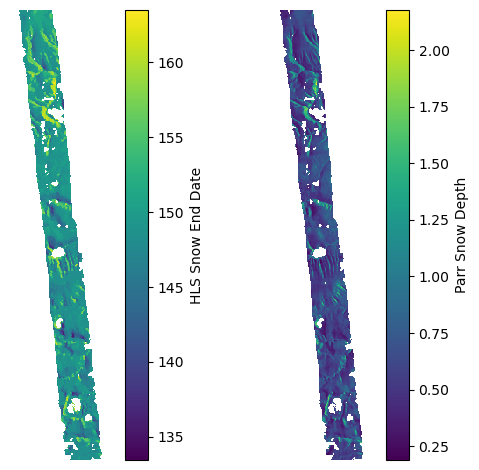

In [79]:
plt.subplot(1,2,1)
ax1 = hls_hv.plot()
plt.axis('off')
plt.title('')
ax1.axes.set_aspect('equal')

plt.subplot(1,2,2)
ax2 = parr_hv.plot()
plt.axis('off')
plt.title('')
ax2.axes.set_aspect('equal')

plt.tight_layout()
plt.show()

In [80]:
print('From xarray: ' + str(xr.corr(hls_hv, parr_hv, dim = ['x', 'y']).compute().item()))

# Flatten
hls_hv_n = hls_hv.to_numpy().flatten()
parr_hv_n = parr_hv.to_numpy().flatten()

# Drop null
hls_hv_n = hls_hv_n[~np.isnan(hls_hv_n)]
parr_hv_n = parr_hv_n[~np.isnan(parr_hv_n)]

print('From scipy:' + str(pearsonr(hls_hv_n, parr_hv_n)[0]) + ', pval: ' + str(pearsonr(hls_hv_n, parr_hv_n)[1]))

From xarray: 0.7360420227050781
From scipy:0.73604196, pval: 0.0


18954
18954


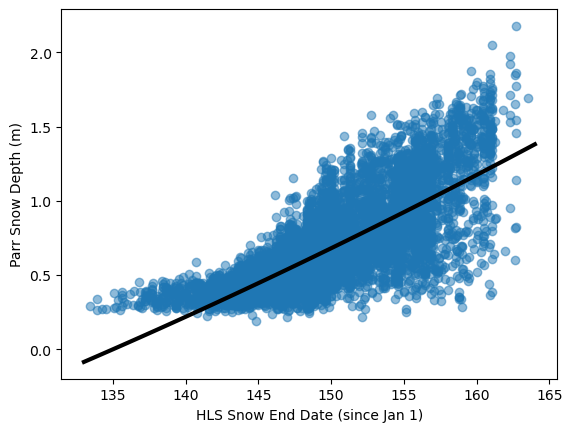

In [81]:
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(np.array(hls_hv_n).reshape(-1, 1), parr_hv_n)
x_reg = np.arange(math.floor(hls_hv_n.min()), math.ceil(hls_hv_n.max()) + 1)  #np.arange(int(hls_hv.min()), int(hls_hv.max())) 
y_reg = model.predict(x_reg.reshape(-1, 1))

plt.scatter(x = hls_hv_n, y = parr_hv_n, alpha = 0.5)
plt.plot(x_reg, y_reg, color = 'black', linewidth = 3)

plt.xlabel('HLS Snow End Date (since Jan 1)')
plt.ylabel('Parr Snow Depth (m)')

print(len(hls_hv_n))
print(len(parr_hv_n))

plt.show()

31


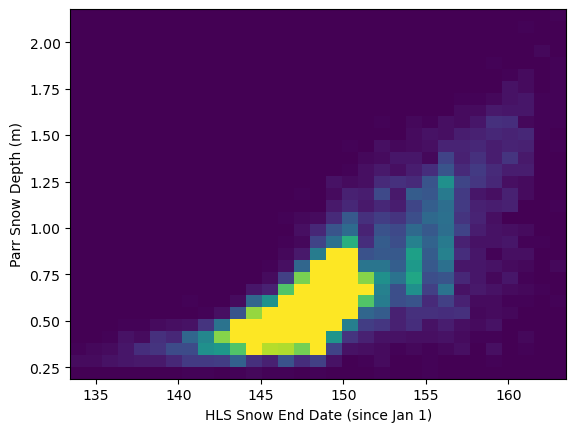

In [82]:
bins = math.ceil(hls_hv_n.max()) - math.floor(hls_hv_n.min())  #int(hls_hv.max() - hls_hv.min())
print(bins)

heatmap, xedges, yedges = np.histogram2d(x = hls_hv_n, y = parr_hv_n, bins = bins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent = extent, origin='lower', vmin = 0, vmax = 100, aspect = 'auto')

plt.xlabel('HLS Snow End Date (since Jan 1)')
plt.ylabel('Parr Snow Depth (m)')

plt.show()

In [83]:
x_reg

array([133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164])

In [84]:
parr_hv_daily = []
ticks_hv = []
pixels_hv = []

for day in x_reg: # From above, all but math.ceil

    # Data for boxplolts
    daily_arr = parr_hv_n[(hls_hv_n >= day) & (hls_hv_n < day + 1)]
    parr_hv_daily.append(daily_arr)

    # Tick labels
    ticks_hv.append(str(day))

    # Pixels
    #pixels.append(len(daily_arr) / len(parr_hv)) # Fraction
    pixels_hv.append(len(daily_arr))

# Normalize pixels so max value = 1
pixels_hv_n = [day / max(pixels_hv) for day in pixels_hv]

print(len(parr_hv_daily))
#ticks
#parr_hv_daily
#pixels

32


C:\Users\mbonney\AppData\Local\Temp\ipykernel_26568\2231942505.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(parr_hv_daily, labels = ticks_hv, widths = pixels_hv_n, medianprops = dict(linewidth = 0), flierprops = dict(marker = '.', markersize = 1))


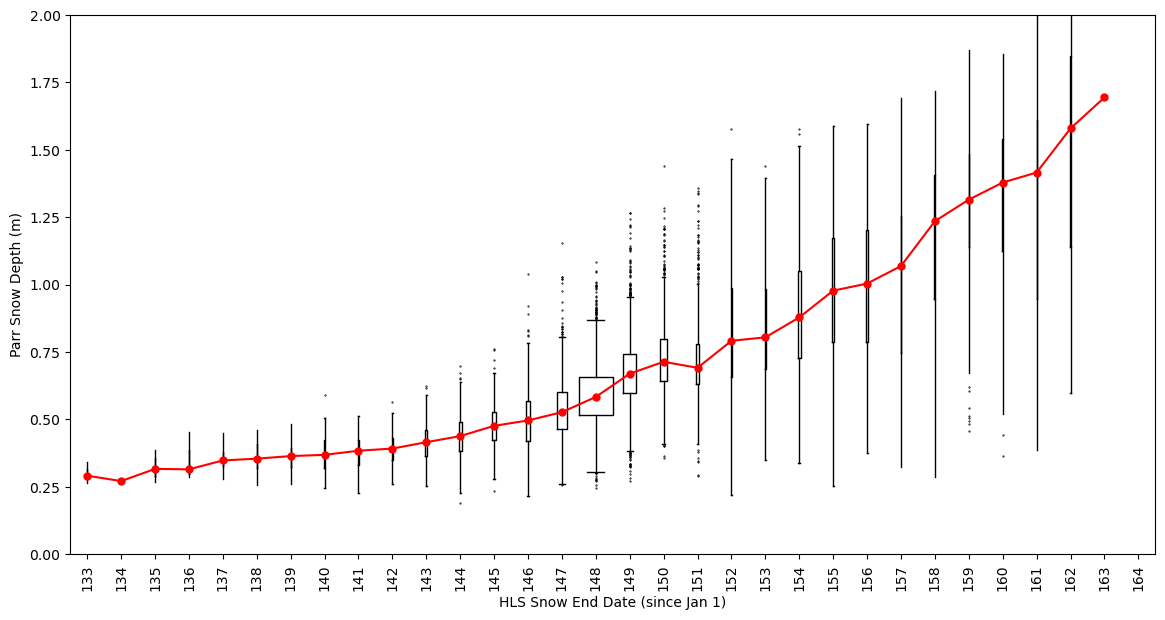

In [85]:
plt.figure(figsize = (14, 7))

boxplot = plt.boxplot(parr_hv_daily, labels = ticks_hv, widths = pixels_hv_n, medianprops = dict(linewidth = 0), flierprops = dict(marker = '.', markersize = 1)) 
                      
X = []
Y = []

for m in boxplot['medians']:
    [[x0, x1] , [y0, y1]] = m.get_data()
    if not np.isnan(y0):
        X.append(np.mean((x0, x1)))
        Y.append(np.mean((y0, y1)))

plt.plot(X, Y, c = 'red', marker = 'o', markersize = 5)

plt.xticks(rotation ='vertical')

plt.xlabel('HLS Snow End Date (since Jan 1)')
plt.ylabel('Parr Snow Depth (m)')

plt.ylim((0, 2)) # 0 - 2 m

plt.show()

In [86]:
# med = stats.median(parr_hv)
# sd = stats.stdev(parr_hv)

# ticks = []
# parr_hv_classes = []
# pixels = []

# # Define classes
# n_scour = math.floor(med / sd) # Number of full sds below median
# n_drift = math.ceil((2 - med) / sd + 1) # Number of times med + sd fit into 2m, +1

# for scour in range(n_scour):
#     if scour == n_scour - 1:
#         lt = med - (sd * scour)
#         tick = 'Scour ' + str(scour) + ' (<' + str(round(lt, 2)) + 'm)'
#         data = hls_hv[parr_hv < lt]
#     else:
#         mt = med - (sd * (scour + 1))
#         lt = med - (sd * scour)
#         tick = 'Scour ' + str(scour) + ' (' + str(round(mt, 2)) + '-' + str(round(lt, 2)) + 'm)'
#         data = hls_hv[(parr_hv >= mt) & (parr_hv < lt)]     
#     ticks.insert(0, tick)
#     parr_hv_classes.insert(0, data)
#     pixels.insert(0, len(data))

# for drift in range(n_drift):
#     if drift == n_drift - 1:
#         mt = med + (sd * drift)
#         tick = 'Drift ' + str(drift) + ' (>' + str(round(mt, 2)) + 'm)'
#         data = hls_hv[parr_hv >= mt]
#     else:
#         mt = med + (sd * drift)
#         lt = med + (sd * (drift + 1))
#         tick = 'Drift ' + str(drift) + ' (' + str(round(mt, 2)) + '-' + str(round(lt, 2)) + 'm)'
#         data = hls_hv[(parr_hv >= mt) & (parr_hv < lt)]
#     ticks.append(tick)
#     parr_hv_classes.append(data)
#     pixels.append(len(data))

# # Normalize pixels so max value = 1
# pixels_n = [cla / max(pixels) for cla in pixels]
    
# ticks

In [87]:
# plt.figure(figsize = (5, 5))

# boxplot = plt.boxplot(parr_hv_classes, labels = ticks, widths = pixels_n, vert = False, medianprops = dict(color = 'red', linewidth = 3), flierprops = dict(marker = '.', markersize = 5)) 
                    
# plt.xlabel('HLS Snow End Date (since Jan 1)')
# plt.ylabel('Parr Snow Depth')

# plt.show()

## CLPX

In [88]:
hls_clpx = xr.where(parr_clpx.isnull(), np.nan, hls_clpx)
hls_clpx.rio.write_crs(crs, inplace = True)
print(parr_clpx.isnull().sum().item())
print(hls_clpx.isnull().sum().compute().item())

hls_clpx = hls_clpx.rename('HLS Snow End Date')
parr_clpx = parr_clpx.rename('Parr Snow Depth')

94995
94995


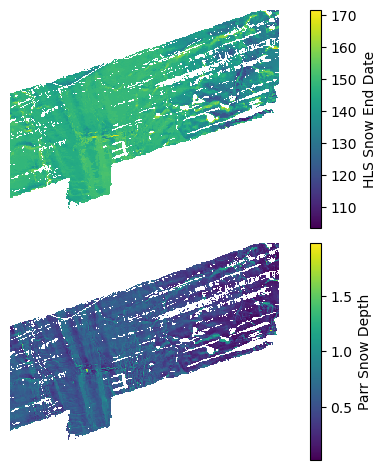

In [89]:
plt.subplot(2,1,1)
ax1 = hls_clpx.plot()
plt.axis('off')
plt.title('')
ax1.axes.set_aspect('equal')

plt.subplot(2,1,2)
ax2 = parr_clpx.plot()
plt.axis('off')
plt.title('')
ax2.axes.set_aspect('equal')

plt.tight_layout()
plt.show()

In [90]:
print('From xarray: ' + str(xr.corr(hls_clpx, parr_clpx, dim = ['x', 'y']).compute().item()))

# Flatten
hls_clpx_n = hls_clpx.to_numpy().flatten()
parr_clpx_n = parr_clpx.to_numpy().flatten()

# Drop null
hls_clpx_n = hls_clpx_n[~np.isnan(hls_clpx_n)]
parr_clpx_n = parr_clpx_n[~np.isnan(parr_clpx_n)]

print('From scipy:' + str(pearsonr(hls_clpx_n, parr_clpx_n)[0]) + ', pval: ' + str(pearsonr(hls_clpx_n, parr_clpx_n)[1]))

From xarray: 0.7666743397712708
From scipy:0.7666745, pval: 0.0


74465
74465


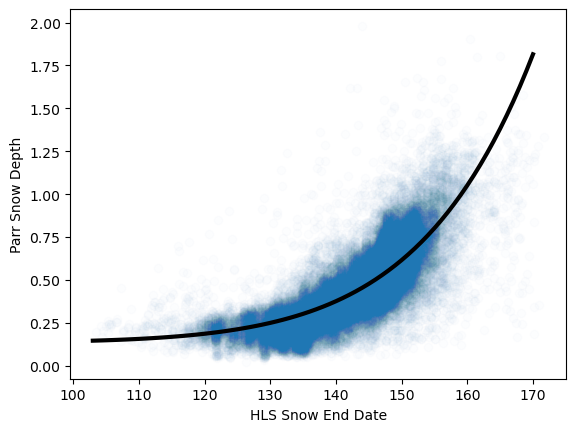

In [91]:
model = make_pipeline(PolynomialFeatures(10), LinearRegression())
model.fit(np.array(hls_clpx_n).reshape(-1, 1), parr_clpx_n)
x_reg = np.arange(int(hls_clpx_n.min()), int(hls_clpx_n.max())) #np.arange(11)
y_reg = model.predict(x_reg.reshape(-1, 1))

plt.scatter(x = hls_clpx_n, y = parr_clpx_n, alpha = 0.01)
plt.plot(x_reg, y_reg, color = 'black', linewidth = 3)

plt.xlabel('HLS Snow End Date')
plt.ylabel('Parr Snow Depth')

print(len(hls_clpx_n))
print(len(parr_clpx_n))

plt.show()

68


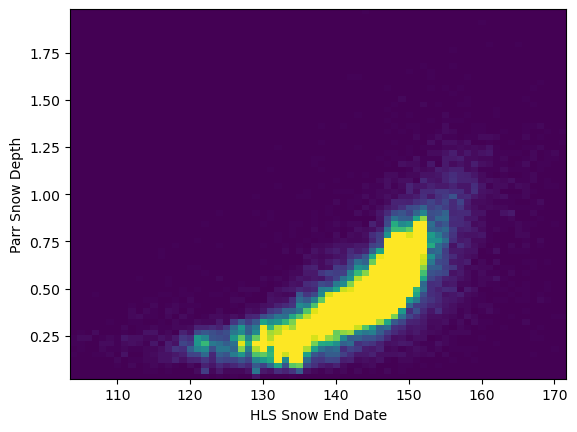

In [92]:
bins = int(hls_clpx_n.max() - hls_clpx_n.min())
print(bins)

heatmap, xedges, yedges = np.histogram2d(x = hls_clpx_n, y = parr_clpx_n, bins = bins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent = extent, origin='lower', vmin = 0, vmax = 100, aspect = 'auto')

plt.xlabel('HLS Snow End Date')
plt.ylabel('Parr Snow Depth')

plt.show()

In [93]:
parr_clpx_daily = []
ticks_clpx = []
pixels_clpx = []

for day in x_reg: # From above, all but math.ceil

    # Data for boxplolts
    daily_arr = parr_clpx_n[(hls_clpx_n >= day) & (hls_clpx_n < day + 1)]
    parr_clpx_daily.append(daily_arr)

    # Tick labels
    ticks_clpx.append(str(day))

    # Pixels
    #pixels.append(len(daily_arr) / len(parr_clpx)) # Fraction
    pixels_clpx.append(len(daily_arr))

# Normalize pixels so max value = 1
pixels_clpx_n = [day / max(pixels_clpx) for day in pixels_clpx]

print(len(parr_clpx_daily))
#ticks
#parr_clpx_daily
#pixels

68


C:\Users\mbonney\AppData\Local\Temp\ipykernel_26568\2580998082.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(parr_clpx_daily, labels = ticks_clpx, widths = pixels_clpx_n, medianprops = dict(linewidth = 0), flierprops = dict(marker = '.', markersize = 1))


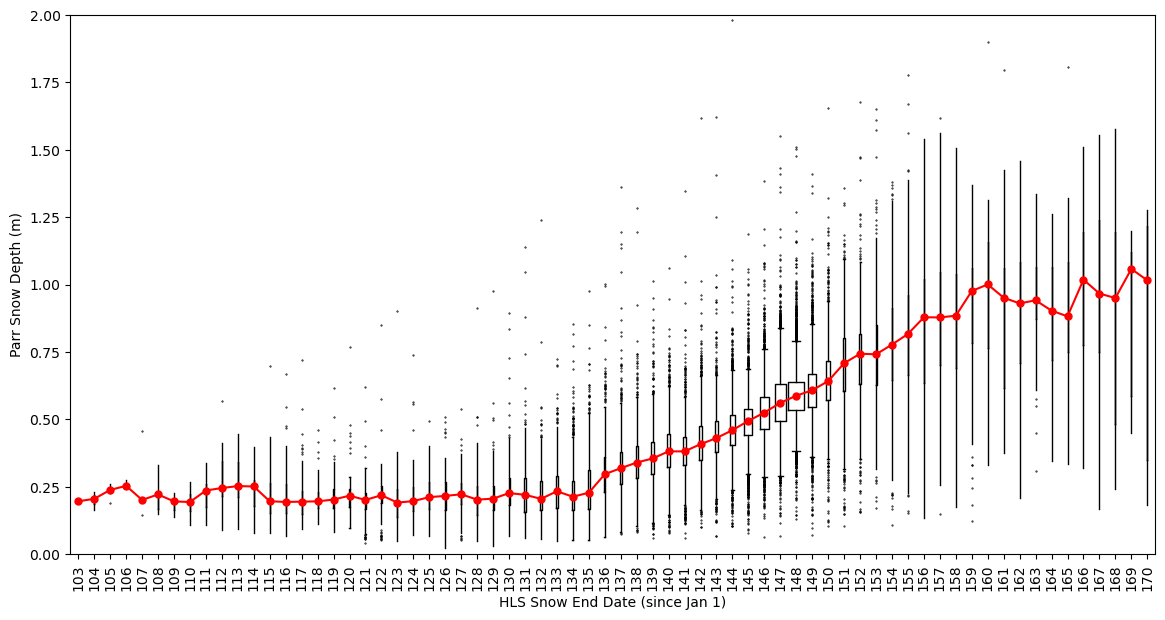

In [94]:
plt.figure(figsize = (14, 7))

boxplot = plt.boxplot(parr_clpx_daily, labels = ticks_clpx, widths = pixels_clpx_n, medianprops = dict(linewidth = 0), flierprops = dict(marker = '.', markersize = 1)) 
                      
X = []
Y = []

for m in boxplot['medians']:
    [[x0, x1] , [y0, y1]] = m.get_data()
    if not np.isnan(y0):
        X.append(np.mean((x0, x1)))
        Y.append(np.mean((y0, y1)))

plt.plot(X, Y, c = 'red', marker = 'o', markersize = 5)

plt.xticks(rotation ='vertical')

plt.xlabel('HLS Snow End Date (since Jan 1)')
plt.ylabel('Parr Snow Depth (m)')

plt.ylim((0, 2)) # 0 - 2 m

plt.show()

In [95]:
# med = stats.median(parr_clpx_n)
# sd = stats.stdev(parr_clpx_n)

# ticks = []
# parr_clpx_classes = []
# pixels = []

# # Define classes
# n_scour = math.floor(med / sd) # Number of full sds below median
# n_drift = math.ceil((2 - med) / sd + 1) # Number of times med + sd fit into 2m, +1

# for scour in range(n_scour):
#     if scour == n_scour - 1:
#         lt = med - (sd * scour)
#         tick = 'Scour ' + str(scour) + ' (<' + str(round(lt, 2)) + 'm)'
#         data = hls_clpx_n[parr_clpx_n < lt]
#     else:
#         mt = med - (sd * (scour + 1))
#         lt = med - (sd * scour)
#         tick = 'Scour ' + str(scour) + ' (' + str(round(mt, 2)) + '-' + str(round(lt, 2)) + 'm)'
#         data = hls_clpx_n[(parr_clpx_n >= mt) & (parr_clpx_n < lt)]     
#     ticks.insert(0, tick)
#     parr_clpx_classes.insert(0, data)
#     pixels.insert(0, len(data))

# for drift in range(n_drift):
#     if drift == n_drift - 1:
#         mt = med + (sd * drift)
#         tick = 'Drift ' + str(drift) + ' (>' + str(round(mt, 2)) + 'm)'
#         data = hls_clpx_n[parr_clpx_n >= mt]
#     else:
#         mt = med + (sd * drift)
#         lt = med + (sd * (drift + 1))
#         tick = 'Drift ' + str(drift) + ' (' + str(round(mt, 2)) + '-' + str(round(lt, 2)) + 'm)'
#         data = hls_clpx[(parr_clpx_n >= mt) & (parr_clpx_n < lt)]
#     ticks.append(tick)
#     parr_clpx_classes.append(data)
#     pixels.append(len(data))

# # Normalize pixels so max value = 1
# pixels_n = [cla / max(pixels) for cla in pixels]
    
# ticks

In [96]:
# plt.figure(figsize = (5, 5))

# boxplot = plt.boxplot(parr_clpx_classes, labels = ticks, widths = pixels_n, vert = False, medianprops = dict(color = 'red', linewidth = 3), flierprops = dict(marker = '.', markersize = 5)) 
                    
# plt.xlabel('HLS Snow End Date (since Jan 1)')
# plt.ylabel('Parr Snow Depth')

# plt.show()

# Figure for Paper

In [97]:
#hls_clpx.mean().compute() # 144.5

<xarray.DataArray 'Parr Snow Depth' ()> Size: 4B
array(0.49645987, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0


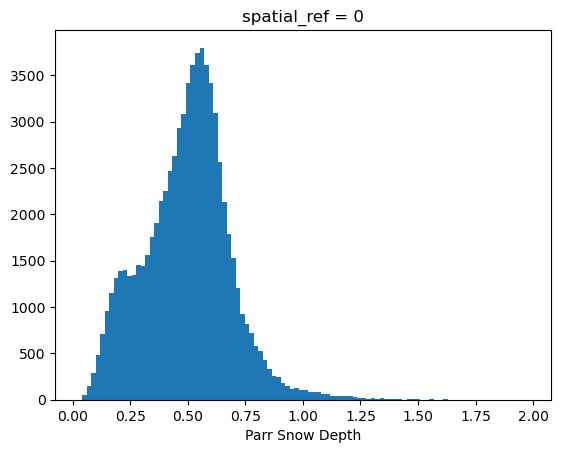

In [98]:
parr_clpx.min() # 0.02
parr_clpx.max() # 1.98
print(parr_clpx.mean()) # 0.5
parr_clpx.plot.hist(bins = 100)
plt.show()

<xarray.DataArray 'HLS Snow End Date' ()> Size: 4B
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0


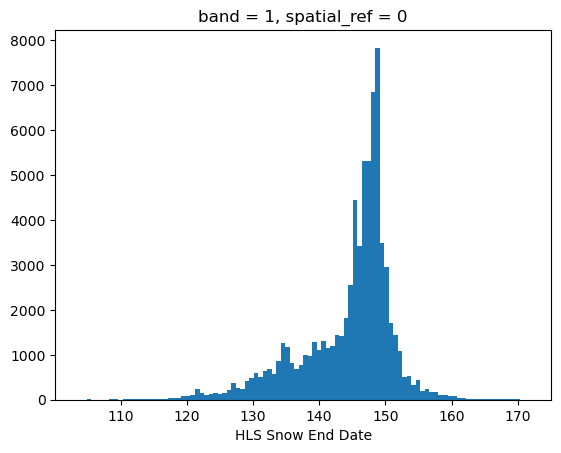

In [99]:
print(hls_clpx.mean())
hls_clpx.plot.hist(bins = 100)
plt.show()

In [100]:
#(hls_clpx < 105).sum().compute() # 4 pixels before April 15
#(hls_clpx < 120).sum().compute() # 521 pixels before May 1

<xarray.DataArray 'Parr Snow Depth' ()> Size: 4B
array(0.640145, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0


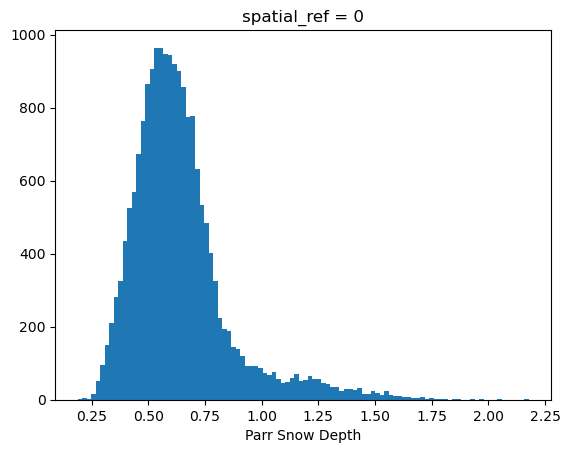

In [101]:
print(parr_hv.mean())
parr_hv.plot.hist(bins = 100)
plt.show()

<xarray.DataArray 'HLS Snow End Date' ()> Size: 4B
array(149.119, dtype=float32)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0


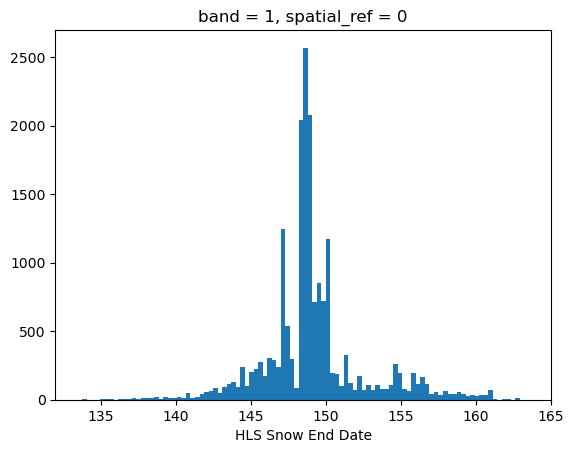

In [102]:
print(hls_hv.mean().compute())
hls_hv.plot.hist(bins = 100)
plt.show()

In [103]:
#parr_clpx_daily2 = parr_clpx_daily[17:] # 120 - 170
parr_clpx_daily2 = parr_clpx_daily[27:-10] # 130 - 160
len(parr_clpx_daily2) 

31

In [104]:
# ticks_clpx2 = ['', '', '105\n(Apr 15)', '', '', '', '', '110\n(Apr 20)', '', '', '', '', '115\n(Apr 25)', '', '', '', '', '120\n(Apr 30)', '', '', '', '', '125\n(May 5)',
#               '', '', '', '', '130\n(May 10)', '', '', '', '', '135\n(May 15)', '', '', '', '', '140\n(May 20)', '', '', '', '', '145\n(May 25)', '', '', '', '', '', '151\n(May 31)', 
#               '', '', '', '', '156\n(Jun 5)', '', '', '', '', '161\n(Jun 10)', '', '', '', '', '166\n(Jun 15)', '', '', '', '']
# ticks_clpx2 = ['', '', '', '', '', '', '', '110\n(Apr 20)', '', '', '', '', '', '', '', '', '', '120\n(Apr 30)', '', '', '', '', '',
#               '', '', '', '', '130\n(May 10)', '', '', '', '', '', '', '', '', '', '140\n(May 20)', '', '', '', '', '', '', '', '', '', '', '151\n(May 31)', 
#               '', '', '', '', '', '', '', '', '', '161\n(Jun 10)', '', '', '', '', '', '', '', '', '']
# ticks2 = ['120\n(Apr 30)', '', '', '', '', '',
#           '', '', '', '', '130\n(May 10)', '', '', '', '', '', '', '', '', '', '140\n(May 20)', '', '', '', '', '', '', '', '', '', '', '151\n(May 31)', 
#           '', '', '', '', '', '', '', '', '', '161\n(Jun 10)', '', '', '', '', '', '', '', '', '']
ticks2 = ['130\n(May 10)', '', '', '', '', '135\n(May 15)', '', '', '', '', '140\n(May 20)', '', '', '', '', '145\n(May 25)', '', '', '', '', '', '151\n(May 31)', 
          '', '', '', '', '156\n(Jun 5)', '', '', '', '']
len(ticks2)

31

In [105]:
#pixels_clpx_n2 = pixels_clpx_n[17:] # 120 - 170
pixels_clpx_n2 = pixels_clpx_n[27:-10] # 130 - 160
len(pixels_clpx_n2) 

31

In [106]:
parr_hv_daily2 = parr_hv_daily.copy() # 120 - 170, add 13 before and 6 after # 130-160 add 3 before and remove 4 after
# parr_hv_daily2.insert(0, np.array([], dtype = 'float32'))
# parr_hv_daily2.insert(0, np.array([], dtype = 'float32'))
# parr_hv_daily2.insert(0, np.array([], dtype = 'float32'))
# parr_hv_daily2.insert(0, np.array([], dtype = 'float32'))
# parr_hv_daily2.insert(0, np.array([], dtype = 'float32'))
# parr_hv_daily2.insert(0, np.array([], dtype = 'float32'))
# parr_hv_daily2.insert(0, np.array([], dtype = 'float32'))
# parr_hv_daily2.insert(0, np.array([], dtype = 'float32'))
# parr_hv_daily2.insert(0, np.array([], dtype = 'float32'))
# parr_hv_daily2.insert(0, np.array([], dtype = 'float32'))
parr_hv_daily2.insert(0, np.array([], dtype = 'float32'))
parr_hv_daily2.insert(0, np.array([], dtype = 'float32'))
parr_hv_daily2.insert(0, np.array([], dtype = 'float32'))
# parr_hv_daily2.append(np.array([], dtype = 'float32'))
# parr_hv_daily2.append(np.array([], dtype = 'float32'))
# parr_hv_daily2.append(np.array([], dtype = 'float32'))
# parr_hv_daily2.append(np.array([], dtype = 'float32'))
# parr_hv_daily2.append(np.array([], dtype = 'float32'))
# parr_hv_daily2.append(np.array([], dtype = 'float32'))
parr_hv_daily2 = parr_hv_daily2[:-4]
len(parr_hv_daily2) 

31

In [107]:
pixels_hv_n2 = pixels_hv_n.copy() # 120 - 170, add 13 before and 6 after # 130-160 add 3 before and remove 4 after
# pixels_hv_n2.insert(0, 0)
# pixels_hv_n2.insert(0, 0)
# pixels_hv_n2.insert(0, 0)
# pixels_hv_n2.insert(0, 0)
# pixels_hv_n2.insert(0, 0)
# pixels_hv_n2.insert(0, 0)
# pixels_hv_n2.insert(0, 0)
# pixels_hv_n2.insert(0, 0)
# pixels_hv_n2.insert(0, 0)
# pixels_hv_n2.insert(0, 0)
pixels_hv_n2.insert(0, 0)
pixels_hv_n2.insert(0, 0)
pixels_hv_n2.insert(0, 0)
# pixels_hv_n2.append(0)
# pixels_hv_n2.append(0)
# pixels_hv_n2.append(0)
# pixels_hv_n2.append(0)
# pixels_hv_n2.append(0)
# pixels_hv_n2.append(0)
pixels_hv_n2 = pixels_hv_n2[:-4]
len(pixels_hv_n2) 

31

## Orignal

C:\Users\mbonney\AppData\Local\Temp\ipykernel_26568\1856706957.py:60: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(hls_clpx_n, parr_clpx_n, 12)
C:\Users\mbonney\AppData\Local\Temp\ipykernel_26568\1856706957.py:125: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(hls_hv_n, parr_hv_n, 12)
C:\Users\mbonney\AppData\Local\Temp\ipykernel_26568\1856706957.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad = -1, w_pad = 1)


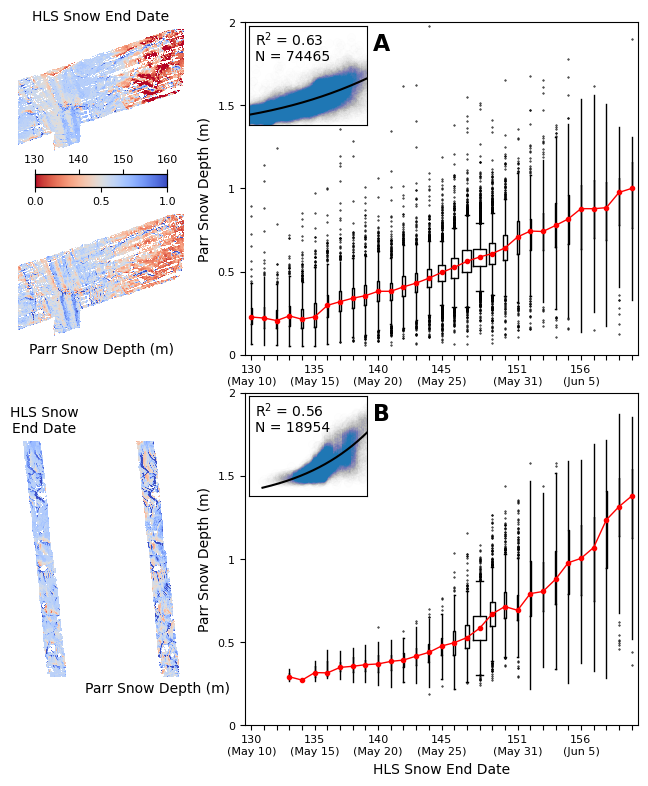

In [108]:
fig = plt.figure(figsize = (6.5, 8))

# HLS Snow End Date Map for CLPX
HLS_map_clpx = plt.subplot2grid((4, 6), (0, 0), colspan = 2)

hls_clpx.plot(ax = HLS_map_clpx, add_labels = False, xticks = [], yticks = [], vmin = 130, vmax = 160, cmap = 'coolwarm_r', add_colorbar = False)
HLS_map_clpx.set_title('HLS Snow End Date', fontsize = 10)
HLS_map_clpx.set_aspect('equal')
HLS_map_clpx.axis('off')

# Parr Snow Depth Map for CLPX
Parr_map_clpx = plt.subplot2grid((4, 6), (1, 0), colspan = 2)

parr_clpx.plot(ax = Parr_map_clpx, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'coolwarm_r', add_colorbar = False)
Parr_map_clpx.set_title('Parr Snow Depth (m)', fontsize = 10, y = -0.1)
Parr_map_clpx.set_aspect('equal')
Parr_map_clpx.axis('off')

# Colorbar
cmap = mpl.cm.coolwarm_r
norm = mpl.colors.Normalize(vmin = 130, vmax = 160)
cax = Parr_map_clpx.inset_axes([0.1, 1.2, 0.8, 0.1])
cax2 = cax.twiny()
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), cax = cax, orientation = 'horizontal')
#cbar.ax.tick_params(labelsize = 8, length = 2) # pad
cax.xaxis.set_ticks_position('top')
cax2.set_xlim(0, 1)
cax2.xaxis.set_ticks_position('bottom')
cax.tick_params(labelsize = 8)#, length = 2)
cax2.tick_params(labelsize = 8)#, length = 2)

# CLPX daily boxplots
Boxplots_clpx = plt.subplot2grid((4, 6), (0, 2), colspan = 4, rowspan = 2)

Boxplots_clpx.text(0.325, 0.935, 'A', fontsize = 16, weight = 'bold', transform = Boxplots_clpx.transAxes, va = 'center')

boxplot_clpx = Boxplots_clpx.boxplot(parr_clpx_daily2, tick_labels = ticks2, widths = pixels_clpx_n2, medianprops = dict(linewidth = 0), flierprops = dict(marker = '.', markersize = 1))

X = []
Y = []

for m in boxplot_clpx['medians']:
    [[x0, x1] , [y0, y1]] = m.get_data()
    if not np.isnan(y0):
        X.append(np.median((x0, x1)))
        Y.append(np.median((y0, y1)))

Boxplots_clpx.plot(X, Y, c = 'red', marker = 'o', markersize = 3, lw = 1)

Boxplots_clpx.set_yticks([0, 0.5, 1, 1.5, 2], ['0', '0.5', '1', '1.5', '2'])
Boxplots_clpx.set_ylabel('Parr Snow Depth (m)', fontsize = 10)
Boxplots_clpx.set_ylim(0, 2)
Boxplots_clpx.tick_params(axis = 'x', labelrotation = 0, labelsize = 8)
Boxplots_clpx.tick_params(axis = 'y', labelsize = 8)
#Boxplots_clpx.set_xlabel('HLS Snow End Date', fontsize = 10)

# CLPX Heatmap and simple stats
heatmap_clpx = Boxplots_clpx.inset_axes([0.01, 0.69, 0.3, 0.3])
heatmap_clpx.scatter(x = hls_clpx_n, y = parr_clpx_n, alpha = 0.005)
coeffs = np.polyfit(hls_clpx_n, parr_clpx_n, 12)
p = np.poly1d(coeffs)
yhat = p(hls_clpx_n)
heatmap_clpx.plot(np.sort(hls_clpx_n), np.sort(yhat), color = 'black', linewidth = 1.5)
ybar = np.sum(parr_clpx_n) / len(parr_clpx_n)    
ssreg = np.sum((yhat - ybar) ** 2)  
sstot = np.sum((parr_clpx_n - ybar) ** 2)   
r2 = round(ssreg / sstot, 2)
heatmap_clpx.text(0.05, 0.8, f'R$^2$ = {r2}', fontsize = 10, transform = heatmap_clpx.transAxes)
heatmap_clpx.text(0.05, 0.65, f'N = {len(hls_clpx_n)}', fontsize = 10, transform = heatmap_clpx.transAxes)
heatmap_clpx.set_xticks([])
heatmap_clpx.set_yticks([])
heatmap_clpx.set_xlim(130,160)
heatmap_clpx.set_ylim(0, 2)
# heatmap, xedges, yedges = np.histogram2d(x = hls_clpx_n[(hls_clpx_n >= 120) & (hls_clpx_n <= 170)], y = parr_clpx_n[(hls_clpx_n >= 120) & (hls_clpx_n <= 170)], bins = 51)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# heatmap_clpx.imshow(heatmap.T, extent = extent, origin='lower', vmin = 0, vmax = 100, aspect = 'auto')
#heatmap_clpx.axis('off')

# HLS Snow End Date Map for HV
HLS_map_hv = plt.subplot2grid((4, 6), (2, 0), rowspan = 2)

#HLS_map_hv.text(1.2, 0.8, 'A', fontsize = 16, weight = 'bold', transform = HLS_map_hv.transAxes, va = 'center')

hls_hv.plot(ax = HLS_map_hv, add_labels = False, xticks = [], yticks = [], vmin = 130, vmax = 160, cmap = 'coolwarm_r', add_colorbar = False)
HLS_map_hv.set_title('HLS Snow\nEnd Date', fontsize = 10)
HLS_map_hv.set_aspect('equal')
HLS_map_hv.axis('off')

# Parr Snow Depth Map for HV
Parr_map_hv = plt.subplot2grid((4, 6), (2, 1), rowspan = 2)

parr_hv.plot(ax = Parr_map_hv, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'coolwarm_r', add_colorbar = False)
Parr_map_hv.set_title('Parr Snow Depth (m)', fontsize = 10, y = -0.1)
Parr_map_hv.set_aspect('equal')
Parr_map_hv.axis('off')

# HV daily boxplots
Boxplots_hv = plt.subplot2grid((4, 6), (2, 2), colspan = 4, rowspan = 2)

Boxplots_hv.text(0.325, 0.935, 'B', fontsize = 16, weight = 'bold', transform = Boxplots_hv.transAxes, va = 'center')

boxplot_hv = Boxplots_hv.boxplot(parr_hv_daily2, tick_labels = ticks2, widths = pixels_hv_n2, medianprops = dict(linewidth = 0), flierprops = dict(marker = '.', markersize = 1))

X = []
Y = []

for m in boxplot_hv['medians']:
    [[x0, x1] , [y0, y1]] = m.get_data()
    if not np.isnan(y0):
        X.append(np.median((x0, x1)))
        Y.append(np.median((y0, y1)))

Boxplots_hv.plot(X, Y, c = 'red', marker = 'o', markersize = 3, lw = 1)

Boxplots_hv.set_yticks([0, 0.5, 1, 1.5, 2], ['0', '0.5', '1', '1.5', '2'])
Boxplots_hv.set_ylabel('Parr Snow Depth (m)', fontsize = 10)
Boxplots_hv.set_ylim(0, 2)
Boxplots_hv.tick_params(axis = 'x', labelrotation = 0, labelsize = 8)
Boxplots_hv.tick_params(axis = 'y', labelsize = 8)
Boxplots_hv.set_xlabel('HLS Snow End Date', fontsize = 10)

# # HV Heatmap and simple stats # Does not have right extent
heatmap_hv = Boxplots_hv.inset_axes([0.01, 0.69, 0.3, 0.3])
heatmap_hv.scatter(x = hls_hv_n, y = parr_hv_n, alpha = 0.005)
coeffs = np.polyfit(hls_hv_n, parr_hv_n, 12)
p = np.poly1d(coeffs)
yhat = p(hls_hv_n)
heatmap_hv.plot(np.sort(hls_hv_n), np.sort(yhat), color = 'black', linewidth = 1.5)
ybar = np.sum(parr_hv_n) / len(parr_hv_n)    
ssreg = np.sum((yhat - ybar) ** 2)  
sstot = np.sum((parr_hv_n - ybar) ** 2)   
r2 = round(ssreg / sstot, 2)
heatmap_hv.text(0.05, 0.8, f'R$^2$ = {r2}', fontsize = 10, transform = heatmap_hv.transAxes)
heatmap_hv.text(0.05, 0.65, f'N = {len(hls_hv_n)}', fontsize = 10, transform = heatmap_hv.transAxes)
heatmap_hv.set_xticks([])
heatmap_hv.set_yticks([])
heatmap_hv.set_xlim(130,160)
heatmap_hv.set_ylim(0, 2)
# heatmap, xedges, yedges = np.histogram2d(x = hls_hv_n[(hls_hv_n >= 120) & (hls_hv_n <= 170)], y = parr_hv_n[(hls_hv_n >= 120) & (hls_hv_n <= 170)], bins = 51)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# heatmap_hv.imshow(heatmap.T, extent = extent, origin='lower', vmin = 0, vmax = 100, aspect = 'auto')
#heatmap_hv.axis('off')

plt.tight_layout(h_pad = -1, w_pad = 1) 

#plt.show()
#fig.get_figure().savefig('Figure 16.tif', dpi = 600, bbox_inches = 'tight', pil_kwargs = {'compression': 'tiff_lzw'})

In [302]:
# model = make_pipeline(PolynomialFeatures(2), LinearRegression())
# model.fit(np.array(hls_clpx_n).reshape(-1, 1), parr_clpx_n)
# x_reg = np.arange(int(hls_clpx_n.min()), int(hls_clpx_n.max())) #np.arange(11)
# y_reg = model.predict(x_reg.reshape(-1, 1))
# # lm = LinearRegression()
# # lm.fit(hls_clpx_n.to_frame(), parr_clpx_n.to_frame())

# #plt.scatter(x = np.log10(hls_clpx_n), y = np.log10(parr_clpx_n), alpha = 0.005)
# plt.scatter(x = hls_clpx_n, y = parr_clpx_n, alpha = 0.005)
# plt.plot(x_reg, y_reg, color = 'black', linewidth = 3)

# plt.xlabel('HLS Snow End Date')
# plt.ylabel('Parr Snow Depth')

# print(len(hls_clpx_n))
# print(len(parr_clpx_n))

# plt.show()

In [256]:
#np.polyfit(hls_clpx_n,parr_clpx_n, deg = 3)

In [301]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression

# x = hls_hv_n
# y = parr_hv_n

# poly = PolynomialFeatures(degree = 12, include_bias = False)
# poly_features = poly.fit_transform(x.reshape(-1, 1))

# poly_reg_model = LinearRegression()
# poly_reg_model.fit(poly_features, y)

# y_predicted = poly_reg_model.predict(poly_features)

# plt.figure(figsize=(10, 6))
# plt.title("Your first polynomial regression – congrats! :)", size=16)
# plt.scatter(x, y)
# plt.plot(x, y_predicted, c="red")
# plt.show()

In [109]:
from scipy.stats import pearsonr # Linear relationship
print(pearsonr(hls_clpx_n, parr_clpx_n)) # R2 = 0.59
print(pearsonr(hls_hv_n, parr_hv_n)) # R2 = 0.54

PearsonRResult(statistic=np.float32(0.7666745), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.73604196), pvalue=np.float64(0.0))


In [231]:
# from scipy.optimize import curve_fit
# curve_fit(xdata = hls_clpx_n, ydata = parr_clpx_n)

In [306]:
# from scipy.stats import pearsonr # Linear relationship
# print(pearsonr(np.log10(hls_clpx_n), np.log10(parr_clpx_n))) # R2 = 0.63
# print(pearsonr(np.log10(hls_hv_n), np.log10(parr_hv_n))) # R2 = 0.53

In [299]:
# np.log10(hls_clpx_n)

In [300]:
# plt.scatter(x = np.log10(hls_hv_n), y = np.log10(parr_hv_n), alpha = 0.005)
# #plt.scatter(x = hls_hv_n, y = parr_hv_n, alpha = 0.005)

# plt.xlabel('HLS Snow End Date')
# plt.ylabel('Parr Snow Depth')

# print(len(hls_clpx_n))
# print(len(parr_clpx_n))

# plt.show()

In [403]:
# import numpy

# # Polynomial Regression
# def polyfit(x, y, degree):
#     results = {}

#     coeffs = numpy.polyfit(x, y, degree)

#      # Polynomial Coefficients
#     results['polynomial'] = coeffs.tolist()

#     # r-squared
#     p = numpy.poly1d(coeffs)
#     # fit values, and mean
#     yhat = p(x)                         # or [p(z) for z in x]
#     ybar = numpy.sum(y)/len(y)          # or sum(y)/len(y)
#     ssreg = numpy.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
#     sstot = numpy.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
#     results['determination'] = ssreg / sstot

#     return results

In [404]:
# coeffs = numpy.polyfit(hls_clpx_n, parr_clpx_n, 12)
# p = numpy.poly1d(coeffs)
# yhat = p(hls_clpx_n)     
# yhat

In [405]:
# #np.sort(yhat)
# test_sort = np.sort(hls_clpx_n)

In [406]:
# plt.plot(test_sort, np.sort(yhat), color = 'black', linewidth = 3)

In [407]:
# hv_pf = polyfit(hls_hv_n, parr_hv_n, 12) # R2 = 0.56
# hv_pf

## Seperate figures

In [113]:
# Maps saved to create in ArcGIS Pro
# hls_clpx.rio.write_nodata(-999, encoded = True, inplace = True) 
# parr_clpx.rio.write_nodata(-999, encoded = True, inplace = True) 
# hls_hv.rio.write_nodata(-999, encoded = True, inplace = True) 
# parr_hv.rio.write_nodata(-999, encoded = True, inplace = True) 

# hls_clpx.rio.to_raster('hls_clpx.tif')
# parr_clpx.rio.to_raster('parr_clpx.tif')
# hls_hv.rio.to_raster('hls_hv.tif')
# parr_hv.rio.to_raster('parr_hv.tif')

C:\Users\mbonney\AppData\Local\Temp\ipykernel_26568\897277803.py:31: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(hls_clpx_n, parr_clpx_n, 12)
C:\Users\mbonney\AppData\Local\Temp\ipykernel_26568\897277803.py:74: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(hls_hv_n, parr_hv_n, 12)


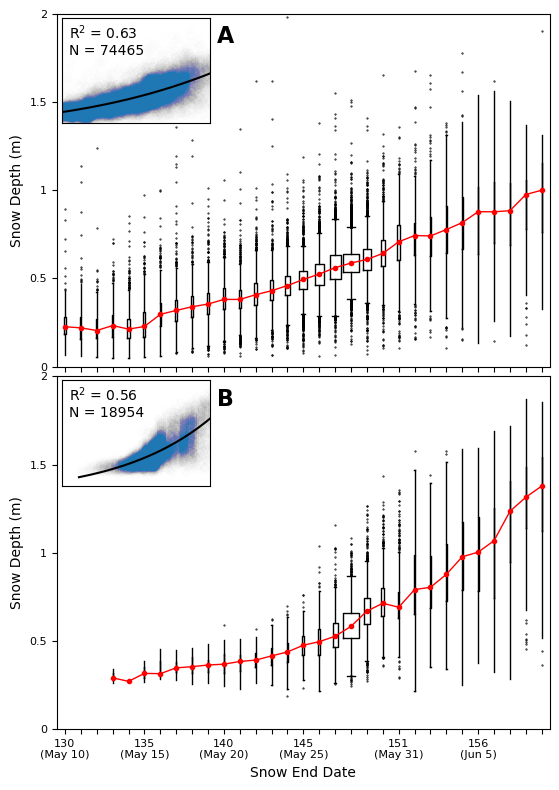

In [132]:
fig = plt.figure(figsize = (8, 8))

# CLPX daily boxplots
Boxplots_clpx = plt.subplot2grid((4, 6), (0, 2), colspan = 4, rowspan = 2)

Boxplots_clpx.text(0.325, 0.935, 'A', fontsize = 16, weight = 'bold', transform = Boxplots_clpx.transAxes, va = 'center')

boxplot_clpx = Boxplots_clpx.boxplot(parr_clpx_daily2, widths = pixels_clpx_n2, medianprops = dict(linewidth = 0), flierprops = dict(marker = '.', markersize = 1))

X = []
Y = []

for m in boxplot_clpx['medians']:
    [[x0, x1] , [y0, y1]] = m.get_data()
    if not np.isnan(y0):
        X.append(np.median((x0, x1)))
        Y.append(np.median((y0, y1)))

Boxplots_clpx.plot(X, Y, c = 'red', marker = 'o', markersize = 3, lw = 1)

Boxplots_clpx.set_yticks([0, 0.5, 1, 1.5, 2], ['0', '0.5', '1', '1.5', '2'])
Boxplots_clpx.set_ylabel('Snow Depth (m)', fontsize = 10)
Boxplots_clpx.set_ylim(0, 2)
Boxplots_clpx.tick_params(axis = 'x', labelrotation = 0, labelsize = 8)
Boxplots_clpx.tick_params(axis = 'y', labelsize = 8)
#Boxplots_clpx.set_xticks([])

# CLPX Heatmap and simple stats
heatmap_clpx = Boxplots_clpx.inset_axes([0.01, 0.69, 0.3, 0.3])
heatmap_clpx.scatter(x = hls_clpx_n, y = parr_clpx_n, alpha = 0.005)
coeffs = np.polyfit(hls_clpx_n, parr_clpx_n, 12)
p = np.poly1d(coeffs)
yhat = p(hls_clpx_n)
heatmap_clpx.plot(np.sort(hls_clpx_n), np.sort(yhat), color = 'black', linewidth = 1.5)
ybar = np.sum(parr_clpx_n) / len(parr_clpx_n)    
ssreg = np.sum((yhat - ybar) ** 2)  
sstot = np.sum((parr_clpx_n - ybar) ** 2)   
r2 = round(ssreg / sstot, 2)
heatmap_clpx.text(0.05, 0.8, f'R$^2$ = {r2}', fontsize = 10, transform = heatmap_clpx.transAxes)
heatmap_clpx.text(0.05, 0.65, f'N = {len(hls_clpx_n)}', fontsize = 10, transform = heatmap_clpx.transAxes)
heatmap_clpx.set_xticks([])
heatmap_clpx.set_yticks([])
heatmap_clpx.set_xlim(130,160)
heatmap_clpx.set_ylim(0, 2)

# HV daily boxplots
Boxplots_hv = plt.subplot2grid((4, 6), (2, 2), colspan = 4, rowspan = 2)

Boxplots_hv.text(0.325, 0.935, 'B', fontsize = 16, weight = 'bold', transform = Boxplots_hv.transAxes, va = 'center')

boxplot_hv = Boxplots_hv.boxplot(parr_hv_daily2, tick_labels = ticks2, widths = pixels_hv_n2, medianprops = dict(linewidth = 0), flierprops = dict(marker = '.', markersize = 1))

X = []
Y = []

for m in boxplot_hv['medians']:
    [[x0, x1] , [y0, y1]] = m.get_data()
    if not np.isnan(y0):
        X.append(np.median((x0, x1)))
        Y.append(np.median((y0, y1)))

Boxplots_hv.plot(X, Y, c = 'red', marker = 'o', markersize = 3, lw = 1)

Boxplots_hv.set_yticks([0, 0.5, 1, 1.5, 2], ['0', '0.5', '1', '1.5', '2'])
Boxplots_hv.set_ylabel('Snow Depth (m)', fontsize = 10)
Boxplots_hv.set_ylim(0, 2)
Boxplots_hv.tick_params(axis = 'x', labelrotation = 0, labelsize = 8)
Boxplots_hv.tick_params(axis = 'y', labelsize = 8)
Boxplots_hv.set_xlabel('Snow End Date', fontsize = 10)

# # HV Heatmap and simple stats # Does not have right extent
heatmap_hv = Boxplots_hv.inset_axes([0.01, 0.69, 0.3, 0.3])
heatmap_hv.scatter(x = hls_hv_n, y = parr_hv_n, alpha = 0.005)
coeffs = np.polyfit(hls_hv_n, parr_hv_n, 12)
p = np.poly1d(coeffs)
yhat = p(hls_hv_n)
heatmap_hv.plot(np.sort(hls_hv_n), np.sort(yhat), color = 'black', linewidth = 1.5)
ybar = np.sum(parr_hv_n) / len(parr_hv_n)    
ssreg = np.sum((yhat - ybar) ** 2)  
sstot = np.sum((parr_hv_n - ybar) ** 2)   
r2 = round(ssreg / sstot, 2)
heatmap_hv.text(0.05, 0.8, f'R$^2$ = {r2}', fontsize = 10, transform = heatmap_hv.transAxes)
heatmap_hv.text(0.05, 0.65, f'N = {len(hls_hv_n)}', fontsize = 10, transform = heatmap_hv.transAxes)
heatmap_hv.set_xticks([])
heatmap_hv.set_yticks([])
heatmap_hv.set_xlim(130,160)
heatmap_hv.set_ylim(0, 2)

plt.tight_layout(h_pad = -1, w_pad = 1) 

#plt.show()
fig.get_figure().savefig('Figure 16.tif', dpi = 600, bbox_inches = 'tight', pil_kwargs = {'compression': 'tiff_lzw'})